In [1]:
import pystac_client
from odc import stac as odc_stac
import xarray as xr
import rioxarray
import numpy as np

from eodag import EODataAccessGateway

In [2]:
from dask.distributed import Client
client = Client(processes=False, threads_per_worker=6,
                n_workers=1, memory_limit='12GB')
client

/home/mschobbe/Documents/projects/dask-flood-mapper/venv/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36333 instead
  warnings.warn(


<Client: 'inproc://128.131.72.130/233855/1' processes=1 threads=6, memory=11.18 GiB>

## EODC catalog

In [3]:
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")
eodc_catalog

<Client id=stac-fastapi>

In [4]:
collections = eodc_catalog.get_collections()

## Cube definitions

In [5]:
crs = "EPSG:4326" # Coordinate Reference System - World Geodetic System 1984 (WGS84) in this case 
res = 0.00018 # 20 meter in degree
chunks = {'time':5, "latitude": 3000, "longitude": 3000}

## Northern Gemany Flood

Storm Babet hit the Denmark and Northern coast at the 20th of October 2023 [Wikipedia](https://en.wikipedia.org/wiki/Storm_Babet).


In [6]:
time_range = "2022-10-11/2022-10-25"
minlon, maxlon = 12.3, 12.9
minlat, maxlat = 54.4, 54.6
bounding_box = [minlon, minlat, maxlon, maxlat]

## Microwave backscatter measurements

In [7]:
collection_sig0 = "SENTINEL1_SIG0_20M"
collection = eodc_catalog.get_collection(collection_sig0)
collection

<CollectionClient id=SENTINEL1_SIG0_20M>

In [8]:
search = eodc_catalog.search(
    collections=collection_sig0,
    bbox=bounding_box,
    datetime=time_range,
)

items_sig0 = search.item_collection()
print(f"On EODC we found {len(items_sig0)} items for the given search query")
items_sig0

On EODC we found 67 items for the given search query


In [9]:
scale = items_sig0[0].assets['VV'].extra_fields.get('raster:bands')[0]['scale'] # raster:bands is STAC raster extension
nodata = items_sig0[0].assets['VV'].extra_fields.get('raster:bands')[0]['nodata']

In [10]:
bands = "VV"
sig0_dc = odc_stac.load(items_sig0,
                        bands=bands,
                        crs=crs,
                        chunks=chunks,
                        resolution=res,
                        bbox=bounding_box,
                        ).\
    rename_vars({"VV": "sig0"})
sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale
sig0_dc = sig0_dc.resample(time="2D").mean().dropna("time", how="all")
sig0_dc = client.persist(sig0_dc)

/home/mschobbe/Documents/projects/dask-flood-mapper/venv/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2024-09-10 16:07:43,374 - distributed.worker.memory - WARNING - gc.collect() took 7.195s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2024-09-10 16:07:43,431 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 8.95 GiB -- Worker memory limit: 11.18 GiB
2024-09-10 16:07:48,881 - distributed.worker.memory - WARNING - Worker is at 75% memory usage. Resuming worker. Process memory: 8.41 GiB -- Worker memory limit: 11.18 GiB
2024-09-10 16:07:56,232 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 9.00 GiB -- Worker memory limit: 11.18 GiB
2024-09-10 16:09:21,073 - dis

In [11]:
sig0_dc.sig0

<xarray.DataArray 'sig0' (time: 6, latitude: 1112, longitude: 3334)> Size: 89MB
dask.array<getitem, shape=(6, 1112, 3334), dtype=float32, chunksize=(1, 1112, 3000), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 9kB 54.6 54.6 54.6 54.6 ... 54.4 54.4 54.4
  * longitude    (longitude) float64 27kB 12.3 12.3 12.3 12.3 ... 12.9 12.9 12.9
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 48B 2022-10-11 2022-10-13 ... 2022-10-23

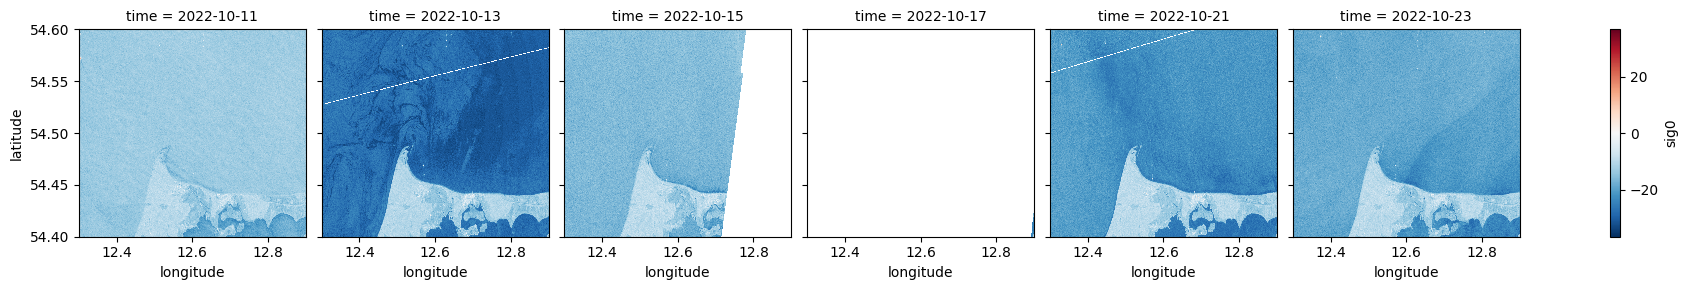

In [12]:
sig0_dc.sig0.plot(col="time")

## Harmonic parameters

In [13]:
collection_hpar = "SENTINEL1_HPAR"
collection = eodc_catalog.get_collection(collection_hpar)
collection

<CollectionClient id=SENTINEL1_HPAR>

In [14]:
search = eodc_catalog.search(
    collections=collection_hpar,
    bbox=bounding_box
)

items_hpar = search.item_collection()
print(f"On EODC we found {len(items_hpar)} items for the given search query")
items_hpar

On EODC we found 19 items for the given search query


In [15]:
scale = items_hpar[0].assets['C1'].extra_fields.get('raster:bands')[0]['scale'] # raster:bands is STAC raster extension
nodata = items_hpar[0].assets['C1'].extra_fields.get('raster:bands')[0]['nodata']

In [16]:
bands = ("C1", "C2", "C3", "M0", "S1", "S2", "S3", "STD", "NOBS")
hpar_dc = odc_stac.load(items_hpar,
                        bands=bands,
                        crs=crs,
                        chunks=chunks,
                        resolution=res,
                        bbox=bounding_box,
                        ).\
    rename_vars({"NOBS": "NOBS_HPAR"}).\
    squeeze("time").\
    drop_vars("time")
hpar_dc = hpar_dc.where(hpar_dc != nodata) / scale
hpar_dc = client.persist(hpar_dc)
hpar_dc 

<xarray.Dataset> Size: 134MB
Dimensions:      (latitude: 1112, longitude: 3334)
Coordinates:
  * latitude     (latitude) float64 9kB 54.6 54.6 54.6 54.6 ... 54.4 54.4 54.4
  * longitude    (longitude) float64 27kB 12.3 12.3 12.3 12.3 ... 12.9 12.9 12.9
    spatial_ref  int32 4B 4326
Data variables:
    C1           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    C2           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    C3           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    M0           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    S1           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    S2           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    S3           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    STD          (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    NOBS_HPAR    (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>

## Local Incidence Angles

In [17]:
collection_plia = "SENTINEL1_MPLIA"
collection = eodc_catalog.get_collection(collection_plia)
collection

<CollectionClient id=SENTINEL1_MPLIA>

In [18]:
search = eodc_catalog.search(
    collections=collection_plia,
    bbox=bounding_box
)

items_plia = search.item_collection()
print(f"On EODC we found {len(items_plia)} items for the given search query")
items_plia

On EODC we found 19 items for the given search query


In [19]:
scale = items_plia[0].assets["MPLIA"].extra_fields.get('raster:bands')[0]['scale'] # raster:bands is STAC raster extension
nodata = items_plia[0].assets["MPLIA"].extra_fields.get('raster:bands')[0]['nodata']

In [20]:
bands = ("MPLIA", "NOBS")
plia_dc = odc_stac.load(items_plia,
                        bands=bands,
                        crs=crs,
                        chunks=chunks,
                        resolution=res,
                        bbox=bounding_box,
                        ).\
    rename_vars({"NOBS": "NOBS_MPLIA"}).\
    squeeze("time").\
    drop_vars("time")
plia_dc = plia_dc.where(plia_dc != nodata) / scale
plia_dc = client.persist(plia_dc)
plia_dc

<xarray.Dataset> Size: 30MB
Dimensions:      (latitude: 1112, longitude: 3334)
Coordinates:
  * latitude     (latitude) float64 9kB 54.6 54.6 54.6 54.6 ... 54.4 54.4 54.4
  * longitude    (longitude) float64 27kB 12.3 12.3 12.3 12.3 ... 12.9 12.9 12.9
    spatial_ref  int32 4B 4326
Data variables:
    MPLIA        (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    NOBS_MPLIA   (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>

## Copernicus DEM from Creodias

In [21]:
# dag = EODataAccessGateway()

In [22]:
# footprint = {'lonmin': bounding_box[0], 'latmin': bounding_box[1], 'lonmax': bounding_box[2], 'latmax': bounding_box[3]}

In [23]:
# dag.providers_config["creodias"].auth.credentials["totp"] = ""
# dag.providers_config["creodias"].download.output_dir = "./data"

In [24]:
# creodias_results = dag.search(productType="COP_DEM_GLO30_DTED",
#                       geom=footprint,
#                       provider="creodias",
#                       )

In [25]:
# pt = dag.download_all(creodias_results)

In [26]:
pt = ["data/DEM1_SAR_DTE_30_20110620T165003_20130707T165326_ADS_000000_TkRV"]
dem_dc = xr.open_mfdataset(pt[0] + "/**/**/*.dt2", engine="rasterio")\
    .squeeze("band")\
    .drop_vars("band")\
    .rename({"band_data": "dem"})

In [27]:
def match_dc(dc, target):
    dc_co = dc.rio.reproject_match(target)\
        .rename_dims({"x": "longitude", "y": "latitude"})\
        .rename_vars({"x": "longitude", "y": "latitude"})
    return dc_co.assign_coords({
        "longitude": target.longitude,
        "latitude": target.latitude,
        "spatial_ref": target.spatial_ref
    })


In [28]:
dem_dc = match_dc(dem_dc, sig0_dc).chunk(chunks=chunks.pop("time", None))
dem_dc = client.persist(dem_dc)
dem_dc

<xarray.Dataset> Size: 15MB
Dimensions:      (latitude: 1112, longitude: 3334)
Coordinates:
    spatial_ref  int32 4B 4326
  * longitude    (longitude) float64 27kB 12.3 12.3 12.3 12.3 ... 12.9 12.9 12.9
  * latitude     (latitude) float64 9kB 54.6 54.6 54.6 54.6 ... 54.4 54.4 54.4
Data variables:
    dem          (latitude, longitude) float32 15MB dask.array<chunksize=(5, 5), meta=np.ndarray>

## Fuse cube

In [29]:
flood_dc = xr.merge([sig0_dc, plia_dc, hpar_dc, dem_dc])
flood_dc

<xarray.Dataset> Size: 267MB
Dimensions:      (time: 6, latitude: 1112, longitude: 3334)
Coordinates:
  * latitude     (latitude) float64 9kB 54.6 54.6 54.6 54.6 ... 54.4 54.4 54.4
  * longitude    (longitude) float64 27kB 12.3 12.3 12.3 12.3 ... 12.9 12.9 12.9
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 48B 2022-10-11 2022-10-13 ... 2022-10-23
Data variables: (12/13)
    sig0         (time, latitude, longitude) float32 89MB dask.array<chunksize=(1, 1112, 3000), meta=np.ndarray>
    MPLIA        (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    NOBS_MPLIA   (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    C1           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    C2           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    C3           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    ...           ...
    S1           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    S2           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    S3           (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    STD          (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    NOBS_HPAR    (latitude, longitude) float32 15MB dask.array<chunksize=(1112, 3000), meta=np.ndarray>
    dem          (latitude, longitude) float32 15MB dask.array<chunksize=(5, 5), meta=np.ndarray>

In [30]:
flood_dc = flood_dc.where(flood_dc.dem>0)

## Likelihoods

### Water

In [31]:
def calc_water_likelihood(dc):
    return  dc.MPLIA * -0.394181 + -4.142015

In [32]:
flood_dc["wbsc"] = calc_water_likelihood(flood_dc)

### Land

In [33]:
def harmonic_expected_backscatter(dc):
    w = np.pi * 2 / 365
    
    t = dc.time.dt.dayofyear
    wt = w * t
    
    M0 = dc.M0
    S1 = dc.S1
    S2 = dc.S2
    S3 = dc.S3
    C1 = dc.C1
    C2 = dc.C2
    C3 = dc.C3
    hm_c1 = (M0 + S1 * np.sin(wt)) + (C1 * np.cos(wt))
    hm_c2 = ((hm_c1 + S2 * np.sin(2 * wt)) + C2 * np.cos(2 * wt))
    hm_c3 = ((hm_c2 + S3 * np.sin(3 * wt)) + C3 * np.cos(3 * wt))
    return hm_c3

In [34]:
flood_dc["hbsc"] = harmonic_expected_backscatter(flood_dc)

## Flood mappingg

In [35]:
def bayesian_flood_decision(dc):
    nf_std = 2.754041
    sig0 = dc.sig0
    std = dc.STD
    wbsc = dc.wbsc
    hbsc = dc.hbsc

    f_prob = (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * \
        (((sig0 - wbsc) / nf_std) ** 2))
    nf_prob = (1.0 / (nf_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * \
        (((sig0 - hbsc) / nf_std) ** 2))
    
    evidence = (nf_prob * 0.5) + (f_prob * 0.5)
    nf_post_prob = (nf_prob * 0.5) / evidence
    f_post_prob = (f_prob * 0.5) / evidence
    return xr.where(np.isnan(f_post_prob) | np.isnan(nf_post_prob), np.nan, np.greater(f_post_prob, nf_post_prob))

In [36]:
flood_dc["decision"] = bayesian_flood_decision(flood_dc)

In [37]:
flood_dc.decision.plot(col="time")

## Postprocessing

In [ ]:
def post_processing(dc):
    dc = dc * np.logical_and(dc.MPLIA >= 27, dc.MPLIA <= 48)
    dc = dc * (dc.hbsc > (dc.wbsc + 0.5 * 2.754041))
    land_bsc_lower = dc.hbsc - 3 * dc.STD
    land_bsc_upper = dc.hbsc + 3 * dc.STD
    water_bsc_upper = dc.wbsc + 3 * 2.754041
    mask_land_outliers = np.logical_and(dc.sig0 > land_bsc_lower, dc.sig0 < land_bsc_upper)
    mask_water_outliers = dc.sig0 < water_bsc_upper
    dc = dc * (mask_land_outliers | mask_water_outliers)
    return  dc * (dc.decision > 0.8)

In [ ]:
flood_dc = post_processing(flood_dc)

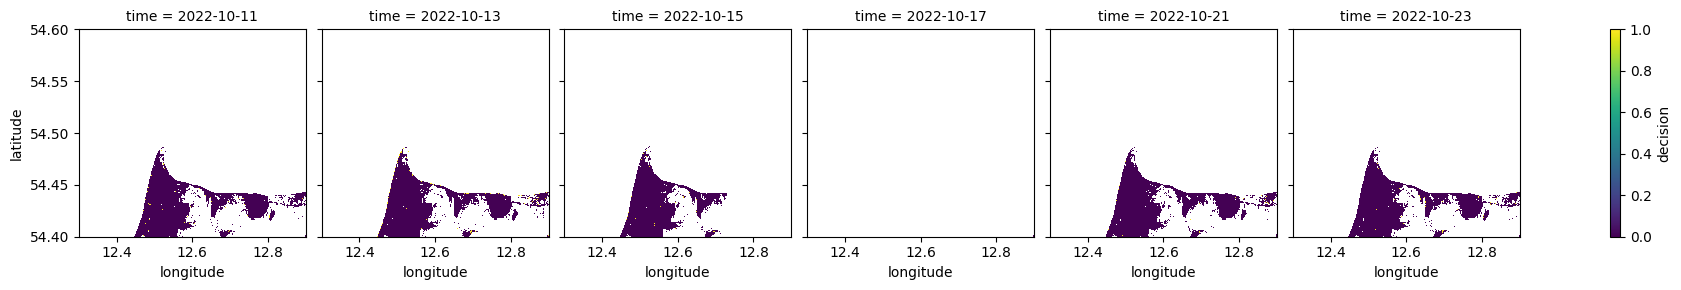

In [ ]:
flood_dc.decision.plot(col="time")

## Removal of Speckles

In [ ]:
flood_dc["decision"] = flood_dc.decision.rolling({"longitude": 5, "latitude": 5}, center=True).median()

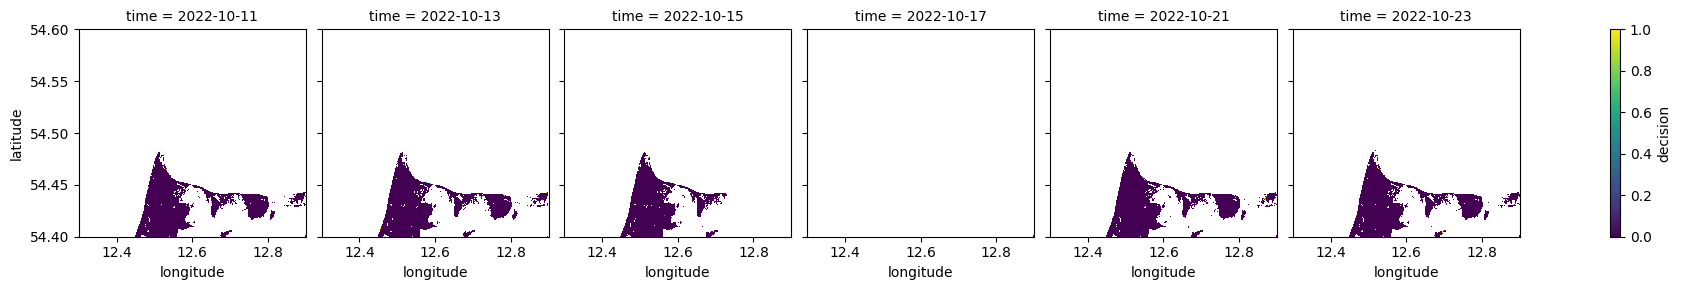

In [47]:
import hvplot.xarray
# levels=[0, 1, 2],
# colors=["#00000000", "#ff0000"]
flood_dc.decision.hvplot.image(dynamic=False, coastline=True)